In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE


In [2]:
#reading the data
credit_card1_info = pd.read_csv('/content/cc_info.csv')
transaction1_info = pd.read_csv('/content/transactions.csv')

In [3]:
credit_card1_info.head(10)

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000
5,1997929794676601,Atlanta,NY,14808,21000
6,5449610971108305,Pittsburgh,PA,15201,6000
7,7482288151831611,Birmingham,NJ,8011,4000
8,8137811493121777,Washington,NH,3280,15000
9,7804216189681274,Los Angeles,CA,90001,20000


In [4]:
transaction1_info.head(10)

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719
5,1003715054175576,2015-10-17 21:28:57,121.60,-80.243565,40.260887
6,1003715054175576,2015-08-29 18:34:04,122.65,-80.238186,40.245928
7,1003715054175576,2015-08-14 21:34:39,98.00,-80.244063,40.249143
8,1003715054175576,2015-09-17 19:20:37,95.20,-2.833179,34.745015
9,1003715054175576,2015-09-11 18:59:04,57.95,-80.287528,40.267874


In [5]:
#check for missing values
credit_card1_info.isnull().sum()

credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64

In [6]:
transaction1_info.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64

In [7]:
credit_card1_info.info()
transaction1_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   date                       294588 non-null  object 
 2   transaction_dollar_amount  294588 non-null  float64
 3   Long                       294588 non-null  float64
 4   Lat                        294588 non-null  float64
dtypes:

### New merged Table

In [8]:
#merge the two data frame
df_credit_card1 = transaction1_info.merge(credit_card1_info, on = 'credit_card')

In [9]:
df_credit_card1.head(5)

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [10]:
sum(df_credit_card1.duplicated())

0

In [11]:
df_credit_card1.describe()

,credit_card,transaction_dollar_amount,Long,Lat,zipcode,credit_card_limit
count,2.945880e+05,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,5.424562e+15,86.008036,-76.235238,40.937669,18073.772516,15502.053716
std,2.555803e+15,124.655954,20.135015,5.391695,23945.510551,7956.291556
min,1.003715e+15,0.010000,-179.392887,-68.046553,690.000000,2000.000000
25%,3.344214e+15,29.970000,-80.209708,40.487726,3280.000000,10000.000000
50%,5.353426e+15,58.470000,-73.199737,42.403066,5820.000000,15000.000000
75%,7.646245e+15,100.400000,-72.091933,43.180015,18612.000000,20000.000000
max,9.999757e+15,999.970000,179.917513,78.914330,98401.000000,55000.000000


In [12]:
df_credit_card1.shape

(294588, 9)

In [13]:
df_credit_card1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   date                       294588 non-null  object 
 2   transaction_dollar_amount  294588 non-null  float64
 3   Long                       294588 non-null  float64
 4   Lat                        294588 non-null  float64
 5   city                       294588 non-null  object 
 6   state                      294588 non-null  object 
 7   zipcode                    294588 non-null  int64  
 8   credit_card_limit          294588 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 22.5+ MB


In [14]:
df_credit_card1.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
dtype: int64

In [15]:
df_credit_card1.isna().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
dtype: int64

### Data Visualisation

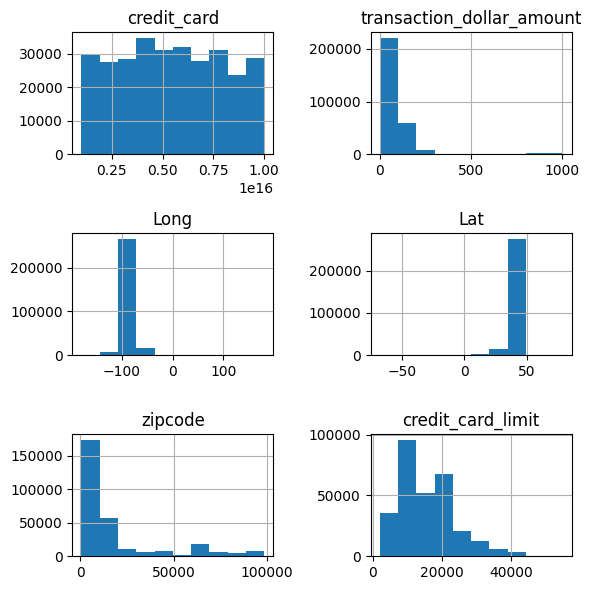

In [16]:
#histogram to see the distribution
df_credit_card1.hist(figsize=(6,6))

plt.tight_layout()
plt.show()


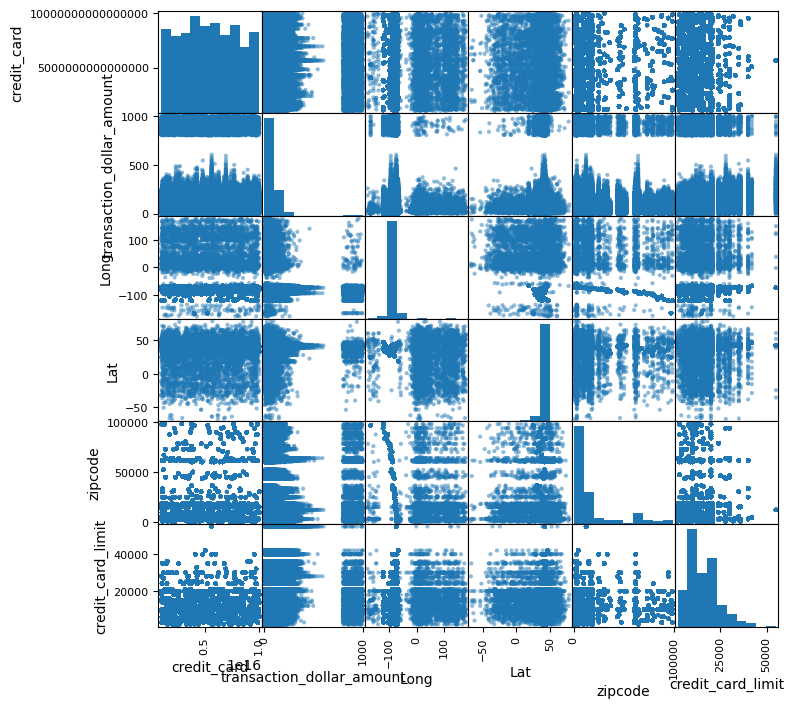

In [17]:
#scatter plot matrix
pd.plotting.scatter_matrix (df_credit_card1,figsize=(8,8))
plt.show()

<ipython-input-18-20152c34ca30>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_credit_card1.corr(), annot=True, cmap='coolwarm', fmt='.2f')


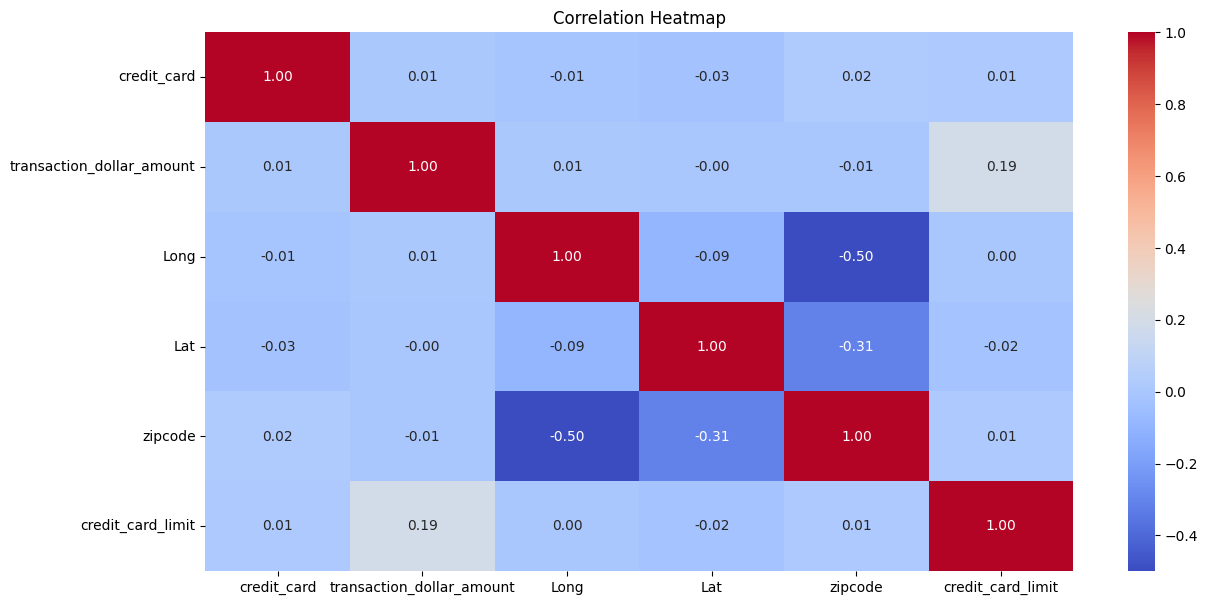

In [18]:
#Heatmap of correlation between numerical features
plt.figure(figsize=(14, 7))
sns.heatmap(df_credit_card1.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### Insights

<Axes: >

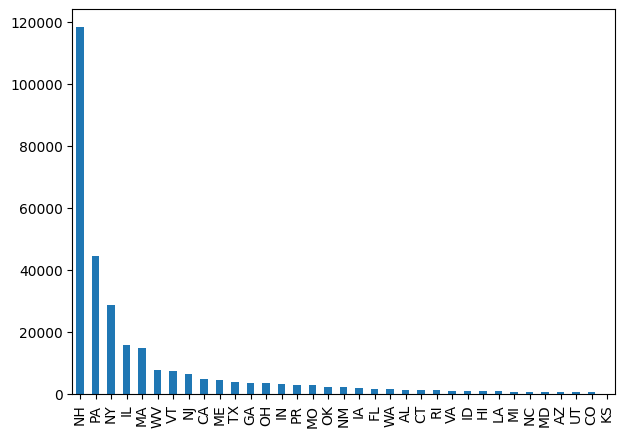

In [19]:
#number of transaction records
df_credit_card1['state'].value_counts().plot(kind='bar',  figsize = (7,5))


In [20]:
import folium
def transactions_on_map(df_credit_card1):
    city_total_transactions = df_credit_card1.groupby('city')['transaction_dollar_amount'].sum().reset_index()

    map_center_lat = df_credit_card1['Lat'].mean()
    map_center_lon = df_credit_card1['Long'].mean()
    map_osm = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=10)

    max_total_transactions = city_total_transactions['transaction_dollar_amount'].max()

    for index, row in city_total_transactions.iterrows():
        city = row['city']
        total_transactions = row['transaction_dollar_amount']

        marker_size = total_transactions / max_total_transactions * 50  # Adjust the scaling factor as needed

        popup_text = f"City: {city}<br>Total Transactions: ${total_transactions:.2f}"

        marker = folium.CircleMarker(
            location=[df_credit_card1[df_credit_card1['city'] == city]['Lat'].mean(), df_credit_card1[df_credit_card1['city'] == city]['Long'].mean()],
            radius=marker_size,
            popup=popup_text,
            tooltip=city,
            fill=True,
            fill_opacity=0.7
        )

        marker.add_to(map_osm)

    return map_osm

if __name__ == "__main__":

    map_total_transactions = transactions_on_map(df_credit_card1)
    display(map_total_transactions)
#Make this Notebook Trusted to load map: File -> Trust N

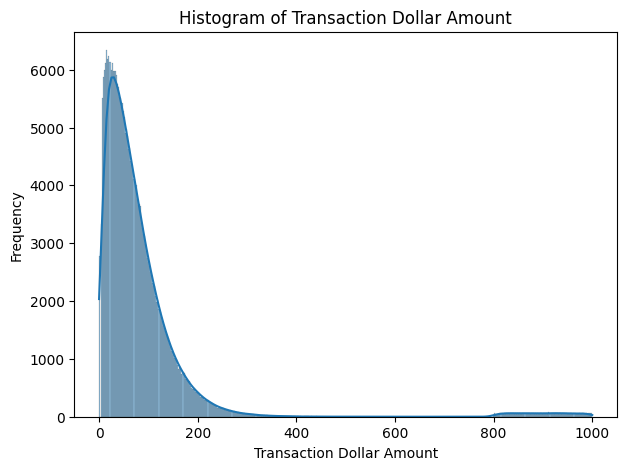

In [21]:
plt.figure(figsize=(7, 5))
sns.histplot(df_credit_card1['transaction_dollar_amount'], kde=True)
plt.title('Histogram of Transaction Dollar Amount')
plt.xlabel('Transaction Dollar Amount')
plt.ylabel('Frequency')
plt.show()

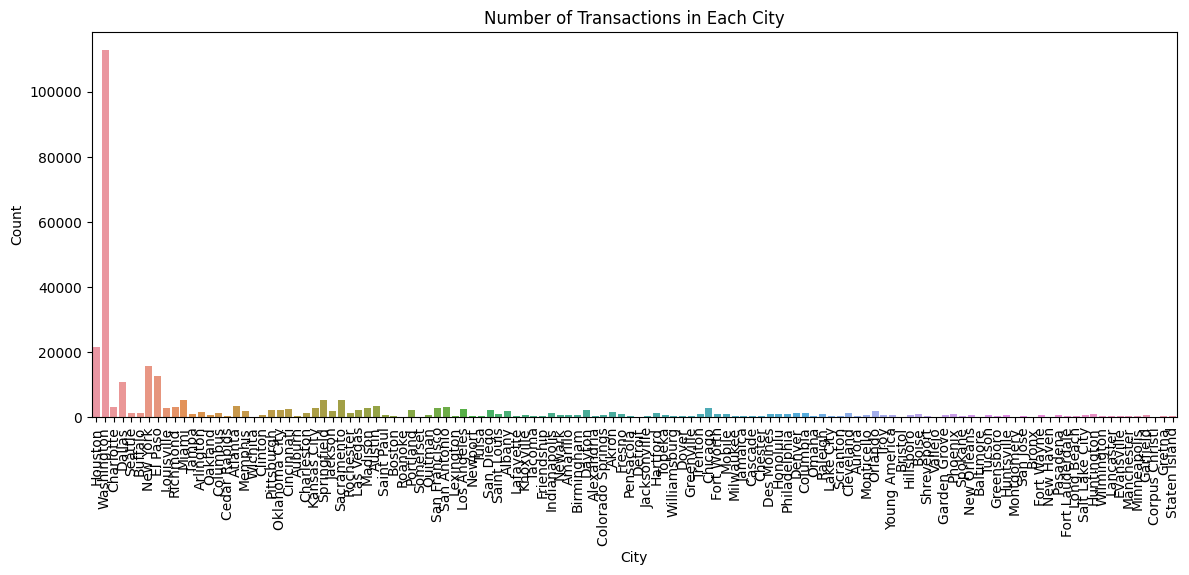

In [22]:
#Bar chart of the count of transactions in each city
plt.figure(figsize=(14, 5))
sns.countplot(data=df_credit_card1, x='city')
plt.title('Number of Transactions in Each City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

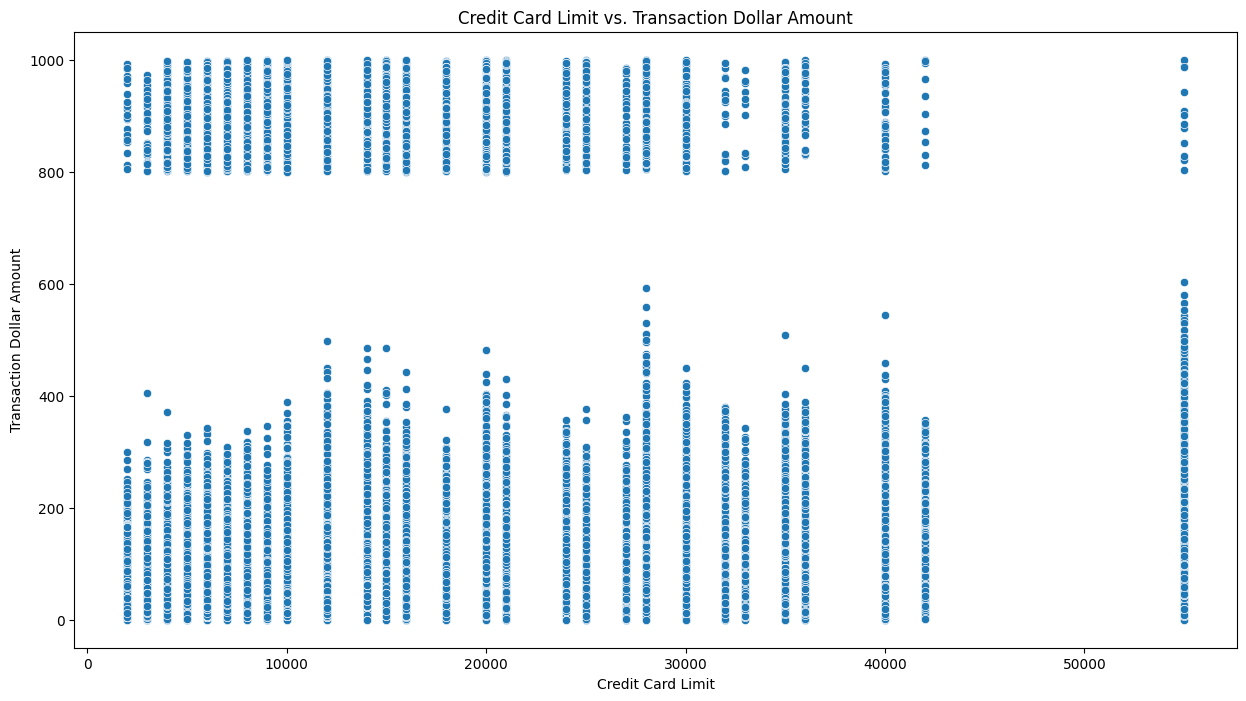

In [23]:
#'transaction_dollar_amount' vs. 'credit_card_limit'
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df_credit_card1, x='credit_card_limit', y='transaction_dollar_amount')
plt.title('Credit Card Limit vs. Transaction Dollar Amount')
plt.xlabel('Credit Card Limit')
plt.ylabel('Transaction Dollar Amount')
plt.show()

In [24]:
df_credit_card1.describe()

,credit_card,transaction_dollar_amount,Long,Lat,zipcode,credit_card_limit
count,2.945880e+05,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,5.424562e+15,86.008036,-76.235238,40.937669,18073.772516,15502.053716
std,2.555803e+15,124.655954,20.135015,5.391695,23945.510551,7956.291556
min,1.003715e+15,0.010000,-179.392887,-68.046553,690.000000,2000.000000
25%,3.344214e+15,29.970000,-80.209708,40.487726,3280.000000,10000.000000
50%,5.353426e+15,58.470000,-73.199737,42.403066,5820.000000,15000.000000
75%,7.646245e+15,100.400000,-72.091933,43.180015,18612.000000,20000.000000
max,9.999757e+15,999.970000,179.917513,78.914330,98401.000000,55000.000000


###Building Fraud Detection Model

In [25]:

class ComprehensiveAnomalyDetection2:

    def __init__(self, df):
        self.df = df.sort_values(by="date")
        self.feature_columns = ['transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit']
        self.labels = None

    def preprocess(self):
        self.df['credit_card_original'] = self.df['credit_card']
        # One-hot encoding for credit card numbers
        self.df = pd.get_dummies(self.df, columns=['credit_card'])

        scaler = StandardScaler()
        self.df[self.feature_columns] = scaler.fit_transform(self.df[self.feature_columns])

    def add_rolling_statistics_for_transaction_count(self, window=30):
        # Calculate the rolling count of transactions for each card
        self.df['rolling_count'] = self.df.groupby('credit_card_original').rolling(window=window, min_periods=0).transaction_dollar_amount.count().reset_index(level=0, drop=True)

        # Calculate the mean and standard deviation for the rolling count of transactions
        self.df['rolling_count_mean'] = self.df.groupby('credit_card_original')['rolling_count'].transform(lambda x: x.rolling(window=window).mean())
        self.df['rolling_count_std'] = self.df.groupby('credit_card_original')['rolling_count'].transform(lambda x: x.rolling(window=window).std())

        # Handle NaN values
        self.df.fillna(0, inplace=True)

        # Identify anomalies based on the criteria: count > mean + 3*std
        self.df['count_anomaly'] = np.where(self.df['rolling_count'] > (self.df['rolling_count_mean'] + 3*self.df['rolling_count_std']), 1, 0)

    def kmeans_detection(self, n_clusters=2):
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        self.df['cluster'] = kmeans.fit_predict(self.df[self.feature_columns])
        self.df['distance_to_center'] = np.linalg.norm(self.df[self.feature_columns].values - kmeans.cluster_centers_[self.df['cluster']], axis=1)
        threshold = np.percentile(self.df['distance_to_center'], 95)
        self.df['kmeans_anomaly'] = (self.df['distance_to_center'] > threshold).astype(int)

    def dbscan_detection(self, eps=0.5, min_samples=5):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.df['dbscan_cluster'] = dbscan.fit_predict(self.df[self.feature_columns])
        self.df['dbscan_anomaly'] = (self.df['dbscan_cluster'] == -1).astype(int)

    def combine_anomalies(self):
        self.df['combined_anomaly'] = self.df[['kmeans_anomaly', 'dbscan_anomaly', 'count_anomaly']].max(axis=1)
        self.labels = self.df['combined_anomaly'].values

    def ensemble_models(self):
        # Splitting the dataset
        X_train, X_test, y_train, y_test = train_test_split(self.df[self.feature_columns], self.labels, test_size=0.2)

        # Applying SMOTE oversampling on training data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Hyperparameter grids
        param_grid_rf = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 5, 7, 10],
            'min_samples_split': [2, 5, 10]
        }

        param_grid_gbt = {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.001, 0.01, 0.1],
            'max_depth': [3, 4, 5,]
        }

          # Model training using GridSearchCV

        rf_search = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1)
        rf_search.fit(X_train_resampled, y_train_resampled)

        gbt_search = GridSearchCV(GradientBoostingClassifier(), param_grid_gbt, cv=5, n_jobs=-1)
        gbt_search.fit(X_train_resampled, y_train_resampled)

        # Model predictions
        rf_preds = rf_search.predict(X_test)
        gbt_preds = gbt_search.predict(X_test)

        # Calculate scores
        rf_score = accuracy_score(y_test, rf_preds)
        gbt_score = accuracy_score(y_test, gbt_preds)

        # Calculate additional metrics for Random Forest
        rf_precision = precision_score(y_test, rf_preds)
        rf_recall = recall_score(y_test, rf_preds)
        rf_f1 = f1_score(y_test, rf_preds)

        # Calculate additional metrics for Gradient Boosting
        gbt_precision = precision_score(y_test, gbt_preds)
        gbt_recall = recall_score(y_test, gbt_preds)
        gbt_f1 = f1_score(y_test, gbt_preds)

        # Display results
        # Print best hyperparameters for Random Forest
        print("\n[INFO] Best hyperparameters for Random Forest:")
        for param, value in rf_search.best_params_.items():
            print(f"{param}: {value}")

        # Print best hyperparameters for Gradient Boosting Trees
        print("\n[INFO] Best hyperparameters for Gradient Boosting Trees:")
        for param, value in gbt_search.best_params_.items():
            print(f"{param}: {value}")
        print("\n[INFO] Ensemble Model Results:")
        print(f"Random Forest Score: {rf_score:.2f}")
        print(f"Random Forest Precision: {rf_precision:.2f}")
        print(f"Random Forest Recall: {rf_recall:.2f}")
        print(f"Random Forest F1 Score: {rf_f1:.2f}")

        print(f"Gradient Boosting Score: {gbt_score:.2f}")
        print(f"Gradient Boosting Precision: {gbt_precision:.2f}")
        print(f"Gradient Boosting Recall: {gbt_recall:.2f}")
        print(f"Gradient Boosting F1 Score: {gbt_f1:.2f}")



    def run(self):
        print("\n[INFO] Preprocessing data...")
        self.preprocess()
        display(self.df.head())

        print("\n[INFO] Adding rolling statistics for transaction count...")
        self.add_rolling_statistics_for_transaction_count()
        display(self.df[['rolling_count', 'rolling_count_mean', 'rolling_count_std', 'count_anomaly']].head())

        print("\n[INFO] Running KMeans anomaly detection...")
        self.kmeans_detection()
        print(f"Number of anomalies detected by KMeans: {self.df['kmeans_anomaly'].sum()}")
        display(self.df[['cluster', 'distance_to_center', 'kmeans_anomaly']].head())

        print("\n[INFO] Running DBSCAN anomaly detection...")
        self.dbscan_detection()
        print(f"Number of anomalies detected by DBSCAN: {self.df['dbscan_anomaly'].sum()}")
        display(self.df[['dbscan_cluster', 'dbscan_anomaly']].head())

        print("\n[INFO] Combining anomalies...")
        self.combine_anomalies()
        print(f"Total anomalies after combining: {self.df['combined_anomaly'].sum()}")
        display(self.df[['kmeans_anomaly', 'dbscan_anomaly', 'count_anomaly', 'combined_anomaly']].head())

        print("\n[INFO] Running ensemble models...")
        self.ensemble_models()




In [26]:
# Usage:
detector = ComprehensiveAnomalyDetection2(df_credit_card1)
detector.run()


[INFO] Preprocessing data...


,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,credit_card_original,credit_card_1003715054175576,...,credit_card_9855217884613002,credit_card_9867492085978660,credit_card_9884182241594028,credit_card_9938969980242308,credit_card_9946917923319410,credit_card_9958678964376192,credit_card_9961694231875562,credit_card_9981251982982618,credit_card_9986135779184360,credit_card_9999757432802760
277391,2015-07-31 09:39:48,-0.545647,-0.685891,-2.049197,New Orleans,LA,70112,-1.445658,9484591448272784,0,...,0,0,0,0,0,0,0,0,0,0
201068,2015-07-31 11:03:48,-0.592977,0.109644,-0.046007,New York,NY,10001,0.313959,7053196367895112,0,...,0,0,0,0,0,0,0,0,0,0
278181,2015-07-31 11:10:14,-0.062557,0.203415,0.402552,Washington,NH,3280,3.079071,9528285469413252,0,...,0,0,0,0,0,0,0,0,0,0
29066,2015-07-31 11:28:55,-0.093041,-0.634066,-0.024732,El Paso,IL,61738,0.565333,1845720274833905,0,...,0,0,0,0,0,0,0,0,0,0
230996,2015-07-31 11:38:51,-0.249632,0.209067,0.421591,Washington,NH,3280,-1.445658,7850942767136368,0,...,0,0,0,0,0,0,0,0,0,0



[INFO] Adding rolling statistics for transaction count...


,rolling_count,rolling_count_mean,rolling_count_std,count_anomaly
277391,1.0,0.0,0.0,1
201068,1.0,0.0,0.0,1
278181,1.0,0.0,0.0,1
29066,1.0,0.0,0.0,1
230996,1.0,0.0,0.0,1



[INFO] Running KMeans anomaly detection...
Number of anomalies detected by KMeans: 14730


,cluster,distance_to_center,kmeans_anomaly
277391,0,2.633912,0
201068,0,0.577546,0
278181,0,3.113167,1
29066,0,0.850963,0
230996,0,1.524750,0



[INFO] Running DBSCAN anomaly detection...
Number of anomalies detected by DBSCAN: 2435


,dbscan_cluster,dbscan_anomaly
277391,0,0
201068,1,0
278181,2,0
29066,1,0
230996,1,0



[INFO] Combining anomalies...
Total anomalies after combining: 41436


,kmeans_anomaly,dbscan_anomaly,count_anomaly,combined_anomaly
277391,0,0,1,1
201068,0,0,1,1
278181,1,0,1,1
29066,0,0,1,1
230996,0,0,1,1



[INFO] Running ensemble models...

[INFO] Best hyperparameters for Random Forest:
max_depth: None
min_samples_split: 2
n_estimators: 150

[INFO] Best hyperparameters for Gradient Boosting Trees:
learning_rate: 0.1
max_depth: 5
n_estimators: 150

[INFO] Ensemble Model Results:
Random Forest Score: 0.83
Random Forest Precision: 0.40
Random Forest Recall: 0.48
Random Forest F1 Score: 0.44
Gradient Boosting Score: 0.83
Gradient Boosting Precision: 0.42
Gradient Boosting Recall: 0.55
Gradient Boosting F1 Score: 0.47
